In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Reshape, GlobalAveragePooling1D
from keras.models import Model
from keras.layers import Layer
from keras import backend as K


class DepthwiseConv1D(Layer):
    def __init__(self, kernel_size, depth_multiplier=1, strides=1, padding='valid', **kwargs):
        super(DepthwiseConv1D, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.depth_multiplier = depth_multiplier
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError('Input shape should be a tuple of 3 dimensions.')
        input_dim = input_shape[2]
        depthwise_kernel_shape = (self.kernel_size, input_dim, self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(shape=depthwise_kernel_shape,
                                                initializer='glorot_uniform',
                                                name='depthwise_kernel')

        self.built = True

    def compute_output_shape(self, input_shape):
        length = input_shape[1]
        if self.padding == 'valid':
            length -= self.kernel_size - 1
        length = (length + self.strides - 1) // self.strides

        return (input_shape[0], length, input_shape[2] * self.depth_multiplier)
    
    def get_config(self):
        config = super().get_config()
        return config

def relu6(x):
    return K.relu(x, max_value=6)

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, classes=1):
    input_shape = (42,1)
    x_input = Input(shape=input_shape)
    print(x_input.shape)
    x = _conv_block(x_input, 32, alpha, strides=2)
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, strides=2, block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, strides=2, block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, strides=2, block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=2, block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout, name='dropout')(x)
    x = Reshape((1, 1024))(x)
    print(x.shape)
    x = Conv1D(classes, 1, padding='same', name='conv_preds')(x)
    print(x.shape)
    x = Reshape((1,1), name='reshape_2')(x)
    x = Activation('sigmoid', name='act_softmax')(x)
    model = Model(inputs=x_input, outputs=x, name='mobilenet')
    return model

def _conv_block(inputs, filters, alpha, kernel=3, strides=1):
    channel_axis = 1
    filters = int(filters * alpha)
    x = Conv1D(filters, kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return Activation('relu', name='conv1_relu')(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=1, block_id=1):
    channel_axis = 1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv1D(3,
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        name='conv_dw_%d' % block_id)(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv1D(pointwise_conv_filters, 1,
               padding='same',
               use_bias=False,
               strides=1,
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return Activation('relu', name='conv_pw_%d_relu' % block_id)(x)

model = MobileNet()
lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


(None, 42, 1)
(None, 1, 1024)
(None, 1, 1)
Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 conv1 (Conv1D)              (None, 21, 32)            96        
                                                                 
 conv1_bn (BatchNormalizatio  (None, 21, 32)           84        
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 21, 32)            0         
                                                                 
 conv_dw_1 (DepthwiseConv1D)  (None, 21, 32)           96        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 21, 32)           84        
 ation)       

 conv_dw_9 (DepthwiseConv1D)  (None, 21, 512)          1536      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 21, 512)          84        
 ation)                                                          
                                                                 
 conv_dw_9_relu (Activation)  (None, 21, 512)          0         
                                                                 
 conv_pw_9 (Conv1D)          (None, 21, 512)           262144    
                                                                 
 conv_pw_9_bn (BatchNormaliz  (None, 21, 512)          84        
 ation)                                                          
                                                                 
 conv_pw_9_relu (Activation)  (None, 21, 512)          0         
                                                                 
 conv_dw_10 (DepthwiseConv1D  (None, 21, 512)          1536      
 )        

C:\Users\PC\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=30,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)
        y_pred_binary = y_pred_binary.reshape(-1, 1)


        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=32,epochs=600, callbacks=callbacks)


Epoch 1/600
32/32 [==============================] - 14s 268ms/step - loss: 0.6706 - accuracy: 0.5871 - val_loss: 0.6936 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/600
32/32 [==============================] - 7s 216ms/step - loss: 0.6219 - accuracy: 0.6605 - val_loss: 0.6949 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 3/600
32/32 [==============================] - 7s 213ms/step - loss: 0.5870 - accuracy: 0.6977 - val_loss: 0.7028 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 4/600
32/32 [==============================] - 7s 209ms/step - loss: 0.5548 - accuracy: 0.7348 - val_loss: 0.7332 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 5/600
32/32 [==============================] - 7s 219ms/step - loss: 0.5514 - accuracy: 0.7221 - val_loss: 0.8132 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 6/600
32/32 [==============================] - 7s 235ms/step - loss: 0.5295 - accuracy: 0.7436 - val_loss: 0.9526 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 7/600
32/32 [====================

Epoch 45/600
32/32 [==============================] - 7s 235ms/step - loss: 0.1945 - accuracy: 0.9217 - val_loss: 1.0025 - val_accuracy: 0.6606 - lr: 1.0000e-04
Epoch 46/600
32/32 [==============================] - 7s 235ms/step - loss: 0.1757 - accuracy: 0.9384 - val_loss: 0.9273 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 47/600
32/32 [==============================] - 7s 231ms/step - loss: 0.1898 - accuracy: 0.9237 - val_loss: 1.1894 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 48/600
32/32 [==============================] - 7s 231ms/step - loss: 0.1750 - accuracy: 0.9256 - val_loss: 1.2180 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 49/600
32/32 [==============================] - 7s 231ms/step - loss: 0.1752 - accuracy: 0.9295 - val_loss: 1.4499 - val_accuracy: 0.5636 - lr: 1.0000e-04
Epoch 50/600
32/32 [==============================] - 7s 233ms/step - loss: 0.1712 - accuracy: 0.9344 - val_loss: 1.0894 - val_accuracy: 0.6091 - lr: 1.0000e-04
Epoch 51/600
32/32 [==============

<Axes: >

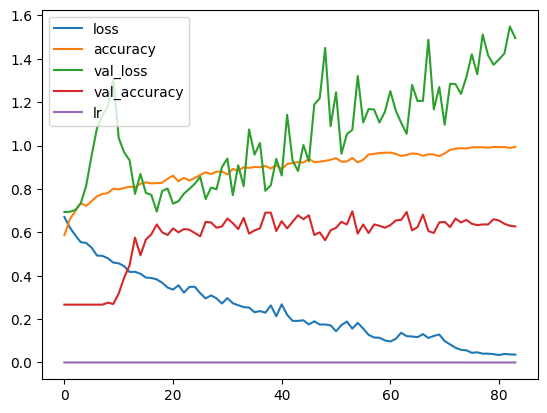

In [6]:
losses = pd.DataFrame(history.history)
losses.plot()

In [7]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_binary = y_pred_binary.reshape(-1, 1)

print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       242
           1       0.39      0.24      0.30        88

    accuracy                           0.70       330
   macro avg       0.57      0.55      0.55       330
weighted avg       0.66      0.70      0.67       330

